Bellı adımlar ile birçok problemi çözebiliyoruz.

Bir veri kümesi bulup onu sayılara dönüştürüyoruz. Bu sayılarda tahmin için kullanılabilecek kalıpları kullanabilmek için bir model oluşturuyoruz(veya mevcut modelleri kullanıyoruz).

**Özel veri kümesi nedir ?**
çalıştığınız belirli bir  soruna ilişkin veri koleksiyonlarıdır.Özel veri kümeleri herhangi bir konuyla ilişkin olabilir.

PyTorch, TorchVision, TorchText, TorchAudio ve TorchRec alan kütüphanelerindeki çeşitli özel veri kümelerini yüklemek için birçok mevcut işlevi içerir.




### 0. Importing PyTorch and setting up device-agnostic code

In [3]:
import torch
from torch import nn

In [4]:
# Setup device - agnostic code
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 1. Get Data

Veri setimizde büyük veri setleriyle başlamayacağız.
Makine öğrenmesi yinelemeli bir süreçtir, küçükten başlayıp, bir şeylerin çalışmasını sağladıktan sonra gerektiğinde artırmaya başlarız.

Veri setimiz Food101 veri setinin bir alt kümesi olacak.101 farklı yemeği sınıflandıracağız.

Fakat şuan 101 yerine 3 tanesiyle çalışacağız.

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

  # parents = True; eğer belirtilen  yolun herhangi bir üst klasörü yok ise Üst klasörü otomatiok oluşturur
  # exisit_ok; Eğer varsa hata vermek yerine devam etmesini sağlar. Böylece birden fazla kez oluşumun önüne geçr

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)


Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### 2.Data Preparation
Amaç, bu veri depolama yapısını almak ve PyTorch ile kullanılabilir bir veri kümesine dönüştürmek olacaktır.

In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [8]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualize an image
**.jpg** ile biten tüm dosyaları bulmak için **pathlib.Path.glob()** kullanarak
tüm görüntü yollarını alın.


Python'un **random.choice()** özelliğini kullanarak rastgele bir görüntü yolu seçin.


Ve görüntülerle çalıştığımız için, **PIL.Image.open()** kullanarak rastgele görüntü yolunu açacağız (PIL, Python Görüntü Kütüphanesi anlamına gelir).
**pathlib.Path.parent.stem** kullanarak görüntü sınıfı adını alın.

Random image path: data/pizza_steak_sushi/train/sushi/2871052.jpg
Image class: sushi
Image height: 512
Image width: 512


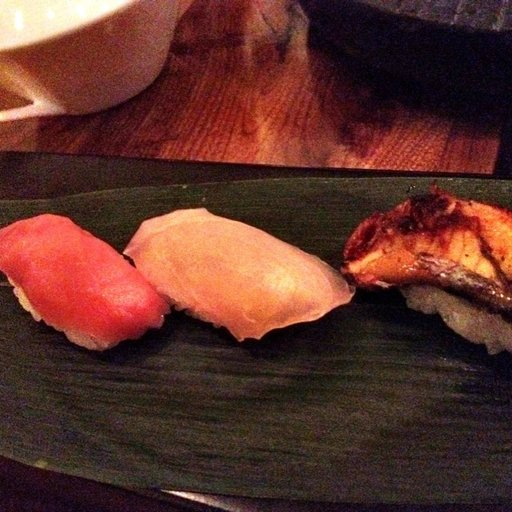

In [9]:
import random
from PIL import Image

#set seed
random.seed(12)

# 1. Get all image paths(* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name( the image class is the name of the directory)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

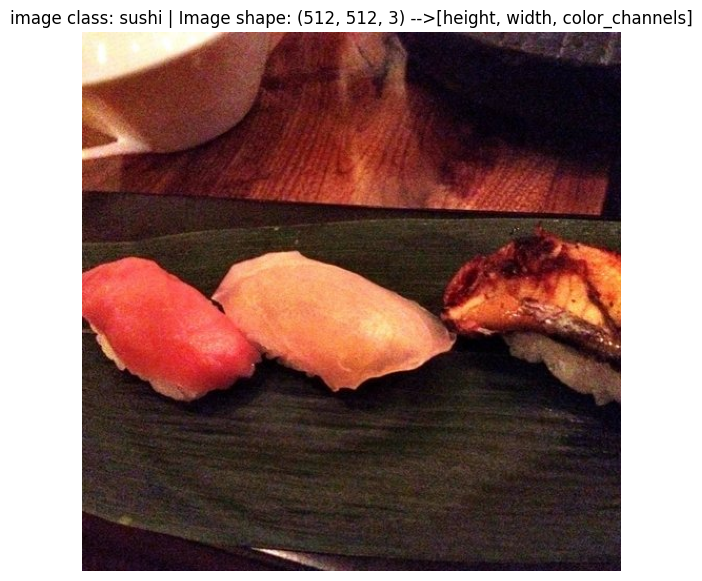

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#Görüntü arraya dönüşüyor
img_as_array = np.asarray(img)

#plot the image with matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title(f'image class: {image_class} | Image shape: {img_as_array.shape} -->[height, width, color_channels]')
plt.axis(False)

### 3.Transforming data

Şimdi Pytorch ile görüntü verilerimi kullanmak için dönüştürme yapacağız.

1. Tensörlere dönüştürücez.
2. Bunu bir torch.utils data.Dataset' e ve ardından .Dataloader'a dönüştürücez

Üzerinde çalıştığımız bağlı olarak Pytorch için birkaç türde önceden oluşturulmuş veri kümesi ve veri kümesi yükleiyicisi var.


Görüntü ile çalıştığımız için, veri kümemiz torchvision.datasets ve hazırlamak için torchvision.transforms'a bakıcağız.

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

#### 3.1 Transforming data with torchvision.transforms

Görüntü klasörlerimiz var fakat bunları tensorlara dönüştüreceğiz. bunu yapabilmek için **torchvision.transforms** modulunu kullanacağız.

torchvision.transforms, görüntüleri biçimlendirmek, tensörlere dönüştürmek ve hatta veri artırma (data augmentation[modelin öğrenmesini zorlaştırmak için verileri değiştirme uygulaması]) amacıyla oluşturulmuş birçok yöntem içerir.

tranform adımları için örnekler;
1.   **transfrom.Resize** ile yeniden boyutlandırma( 512*512 den, 64*64 e)
2.   Görüntülerimizi **transforms.RandomHorizontalFlip()** (Bu, görüntü verilerimizi yapay olarak değiştireceği için bir tür veri artırımı olarak düşünülebilir)


**Torchvision.transforms.Compose()** kullanarak tüm bu adımları derleyebiliriz.


In [12]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64*64
    transforms.Resize(size =(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5),#p = probility of flip, 0.5 = 50 %chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

Bir dönüşüm nesnemiz var. bunları çeşitli görseller üzerinde deneyelim.

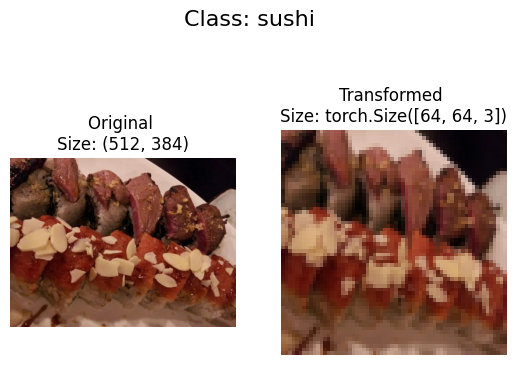

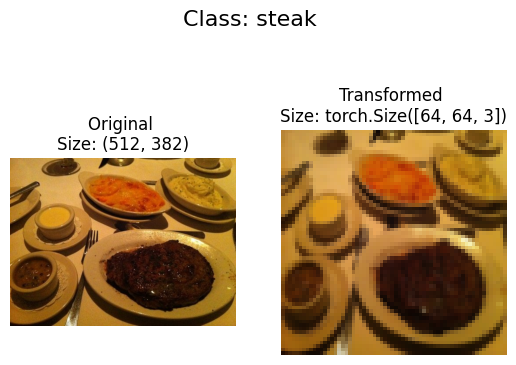

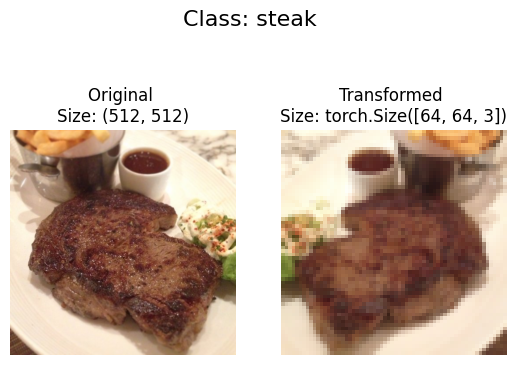

In [13]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original \nSize: {f.size}')
      ax[0].axis('off')


      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize = 16)
plot_transformed_images(image_path_list, transform = data_transform,
                        n=3)

Genelde bir görüntü ne kadar büyükse model o kadar fazla bilgiyi kurtarabilir.


### 4. Option 1: Loading Image Data Using ImageFolder

Verilerimiz standart görüntü sınıflandırma formatında olduğu için **torchvision.datasets.ImageFolder** sınıfını kullanabiliriz.

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir, # görsellerin hedef klasörü,
                                  transform = data_transform,# transforms to perform on data(images)
                                  target_transform= None #transforms to perform on labels
                                  )
test_data = datasets.ImageFolder(root = test_dir,
                                 transform =data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [15]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
img, label = train_data[0][0],train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

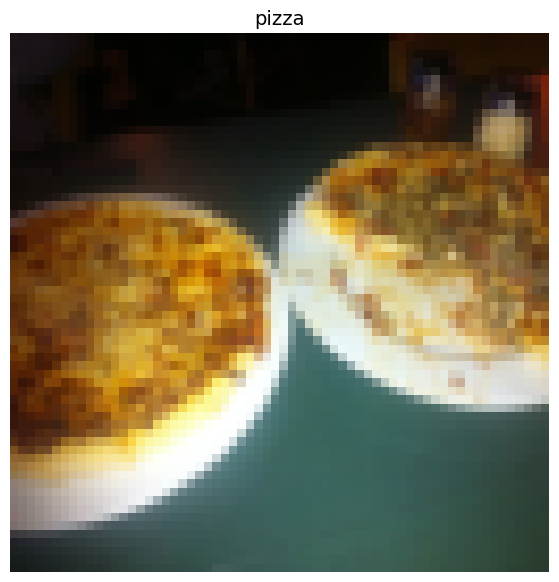

In [18]:
#boyutlarını sırasını değiştirme
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label],fontsize=14)

#### 4.1 Turn Loaded images into DataLoaders
Görüntüleri Pytorch datesets olarak aldık ama şimdi Dataloaders dönüştürüleim.
Bunu **torch.utils.data.DataLoader** kullanarak yapacağız.

Veri Kümeleri Dataloaderlara dönüştürmek yinelenebilir hale getirir, böylece bir model örnekler ve hedefler (özellikler ve etiketler) arasındaki ilişkileri öğrenebilir.

**num_workers:** Verilerin yüklerken kaç adet alt sürecin çalışacağını belirler. Sayı yükseldikçe veri  yüklemek için o kadar fazla işlem gücü kullanılır. **os.cpu_count()** ile sahip olduğunuz işlemci sayısını görebilirsiniz.

In [19]:
os.cpu_count()

2

In [20]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 1,
                              num_workers= 1,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size=1,
                             num_workers = 1,
                             shuffle = False)
""""
Shuffle parametresi veri yükleme sırasında veri örneklerinin karıştırlıp
karıştırılmayacğını belirten bir parametredir.Karıştırma, her eğitim iterasyonunda
modele farklı örnekler sunarak modelin örüntüleri ezberlemesini
veya belli bir sıraya alışmasını engeller. Genelde test veri kümesinde ihtiyaç yoktur.

DataLoader'ın shuffle parametresini True olarak ayarladığınızda,
her bir eğitim iterasyonunda veriler rastgele karıştırılacaktır.
Böylece model her seferinde farklı örneklerle eğitilecektir.
"""
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78d5059809d0>,
 <torch.utils.data.dataloader.DataLoader at 0x78d5059c5d50>)

In [21]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


Dataloader ile bir modeli eğitmek için bir eğitim  ve testdöngüsüyle birlikte kullanabiliriz.

Bunu yapmadan önce bir başka görüntü yükleme seçeneğine bakalım.

### 5. Option 2:Loading Image Data with Custom Dataset

Eğer önceden oluşturulmuş bir veriseti olmasaydı veya sizin probleminiz ile ilişkili olmasaydı, Kendin veri seti oluşturabilirsin.

Bunun pozitif ve negatif tarafları bulunuyor.


In [22]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [23]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Creating a helper function to get class names
Bir dizin yolu verildiğinde sınıf adlarının bir listesini ve sınıf adlarının ve dizinlerinin bir sözlüğünü oluşturabilen bir yardımcı işlev yazalım.


1. Hedef dizini dolaşmak için **os.scandir()** kullanarak sınıf adlarını alır.
1.   Sınıf adları bulunamazsa hata verir (bu durumda dizin yapısında bir sorun olabilir).
2.   Sınıf adlarını, her sınıf için bir tane olmak üzere sayısal etiketlerden oluşan bir sözlüğe dönüştürün.



In [24]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")


Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [25]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [26]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.2 Create a custom Dataset to replicate ImageFolder
Kendi özel veri setimizi oluşturacağız.

**torchvision.datasets.ImageFolder() **işlevselliğini çoğaltmak için bir tane oluşturacağız.

Adımlar:


1.   Altsınıf **torch.utils.data.Dataset**
2.   Alt sınıfımızı bir **targ_dir** parametresi (hedef veri dizini) ve **transform** parametresiyle başlatın (böylece gerekirse verilerimizi dönüştürme seçeneğimiz olur).
3.   **Paths** (hedef resimlerimizin yolları), **transform** (kullanmak isteyebileceğimiz dönüşümler, bu None olabilir), **classes** ve **class_to_idx** (find_classes() fonksiyonumuzdan) için çeşitli nitelikler oluşturun.
4.  Görüntüleri dosyadan yüklemek ve döndürmek için bir işlev oluşturun, bu **PIL** veya **torchvision.io** (görüntü verilerinin girişi / çıkışı için) kullanıyor olabilir.
5. Veri Kümesindeki örnek sayısını döndürmek için **torch.utils.data.Dataset**'in __len__ yönteminin üzerine yazın, bu önerilir ancak gerekli değildir. Bu, len(Dataset)'i çağırabilmeniz içindir.
6. Veri Kümesinden tek bir örnek döndürmek için torch.utils.data.Dataset'in __getitem__ yönteminin üzerine yazın, bu gereklidir.

In [27]:
from torch.utils.data import Dataset

#1.Adım
class ImageFolderCustom(Dataset):

  #2.Adım
  def __init__(self, targ_dir: str, transform = None) -> None:

     #3.Adım
     #Tüm image pathleri al
     self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))#görselin dosya türüne göre güncellenmelidir.
     #Setup transform
     self.transform = transform
     # Create classes and class_to_idx attributes
     self.classes, self.class_to_idx = find_classes(targ_dir)
  #4.adım
  def load_image(self, index: int) -> Image.Image:

    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  #5.adım
  def __len__(self) -> int:

    "Returns the total number of samples."
    return len(self.paths)

  #6.adım
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
     img = self.load_image(index)
     class_name = self.paths[index].parent.name
     class_idx = self.class_to_idx[class_name]

     # Transform if necessary
     if self.transform:
       return self.transform(img), class_idx
     else:
       return img,class_idx

Dataloader.py ile bu kod blogunu kullanabiliriz.


In [28]:
#augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Dont augment test data , only reshape
test_transforms = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor()])

Kendi ImageFolderCustom sınıfımızı kullanarak eğitim görüntülerimizi (train_dir'de bulunan) ve test görüntülerimizi (test_dir'de bulunan) Veri Kümelerine dönüştürelim.

In [29]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78d5059c75b0>,
 <__main__.ImageFolderCustom at 0x78d5059c6b60>)

In [30]:

len(train_data_custom), len(test_data_custom)

(225, 75)

In [31]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [32]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [33]:

# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


####  5.3 Create a function to display random images
Veri Kümelerimizdeki görüntüleri görselleştirmemize yardımcı olacak display_random_images() adında bir yardımcı fonksiyon oluşturalım.


1.   Bir veeri kümesi ve bir diğer parametrelerin sayısını alın. Classes, görüntülenecek görüntü sayısı(n) ve randoom seed gibi.
2.   Ekranın kontrolden çıkmasını önlemek için n =10 resimle sınırlandıracağız.
3.  Random seed ayarla
4. Çizdirmek için rastgele örnek dizinlerinin bir listesini alın (bunun için Python'un random.sample() işlevini kullanabiliriz).
5. Bir matplotlib grafiği kurun.
6. 4. adımda bulunan rastgele örnek dizinleri arasında dolaşın ve bunları matplotlib ile çizin.
7. Örnek görüntülerin HWC (yükseklik, genişlik, renk kanalları) şeklinde olduğundan emin olun, böylece onları çizebiliriz.

In [34]:
# 1. Adım

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  #2.Adım
  if n > 10:
     n = 10
     display_shape = False
     print(f'For display purposes, n shouldnt be larger than 10,setting to 10 and removing shape display.')

  #3. adım
  if seed:
    random.seed(seed)

  # 4.adım
  random_samples_idx =random.sample(range(len(dataset)), k = n)

  # 5.adım
  plt.figure(figsize = (16,8))

  # 6. Adım
  for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        #7.Adım
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

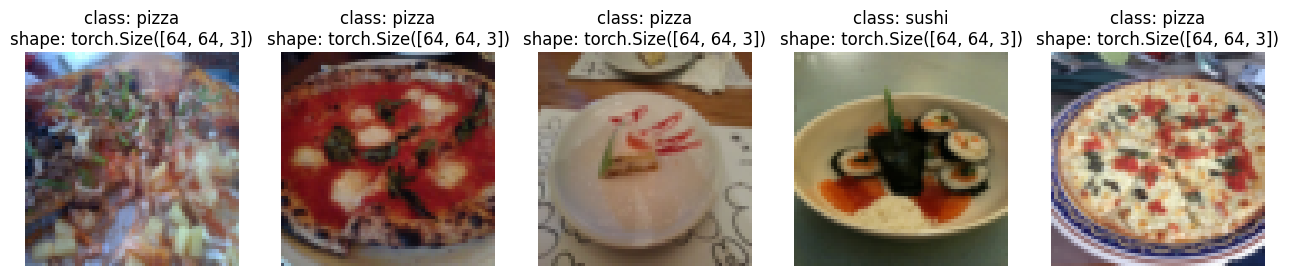

In [35]:
display_random_images(train_data,
                      n=5,
                      classes =class_names,
                      seed = None)

For display purposes, n shouldnt be larger than 10,setting to 10 and removing shape display.


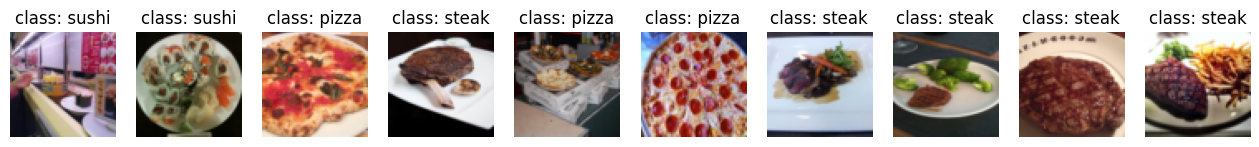

In [36]:
display_random_images(train_data_custom,
                      n =12,
                      classes = class_names,
                      seed = None)

#### 5.4 Turn custom loaded images into DataLoader's

Şimdi özel Dataset'lerimizi DataLoader'lara nasıl dönüştürebiliriz?

Özel Dataset'lerimiz torch.utils.data.Dataset alt sınıfında olduğundan, bunları doğrudan torch.utils.data.DataLoader() ile kullanabiliriz.

Ve daha öncekine çok benzer adımları kullanarak yapabiliriz, ancak bu sefer özel oluşturulmuş Veri Kümelerimizi kullanacağız.


In [37]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle =True
                                     )
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size=1,
                                    num_workers = 0,
                                    shuffle = False
                                    )

In [38]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


###  6. Other forms of transforms (data augmentation)
Verilerimiz üzerinde zaten birkaç dönüşüm gördük, ancak daha pek çok dönüşüm var.

Tranformların amacı görüntülerinizi bir şekilde değiştirmektir.(**torchvision.transforms)**

Bu, görüntülerinizi bir tensöre dönüştürüyor olabilir (daha önce gördüğümüz gibi).Ya da kırpmak veya rastgele bir kısmını silmek veya rastgele döndürmek.Bu tür dönüşümlerin yapılması genellikle veri büyütme(**data augmentation**) olarak adlandırılır.

TrivialAugment, çeşitli PyTorch görüş modellerine yapılan son teknoloji eğitim yükseltmesinde kullanılan bileşenlerden biriydi.

transforms.TrivialAugmentWide() işlevinde dikkat edilmesi gereken ana parametre num_magnitude_bins=31'dir.

Belirli bir dönüşümü uygulamak için bir yoğunluk değerinin ne kadarlık bir aralıkta seçileceğini tanımlar, 0 aralıksız ve 31 maksimum aralıktır (en yüksek yoğunluk için en yüksek şans).


In [39]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins =31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

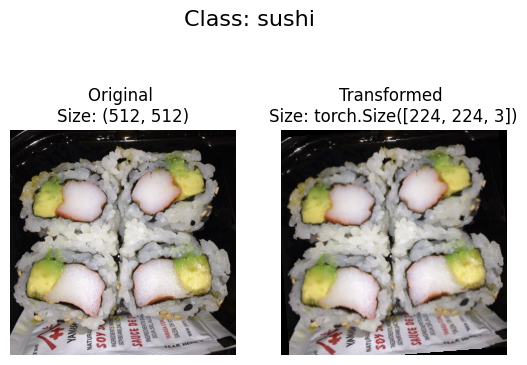

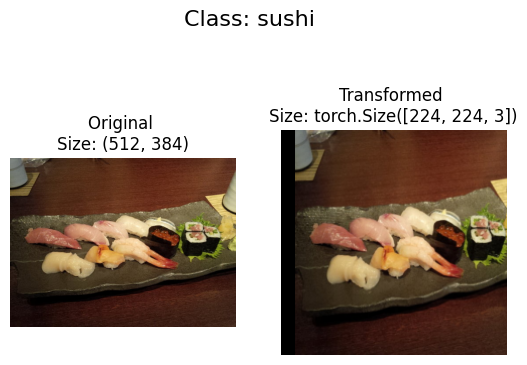

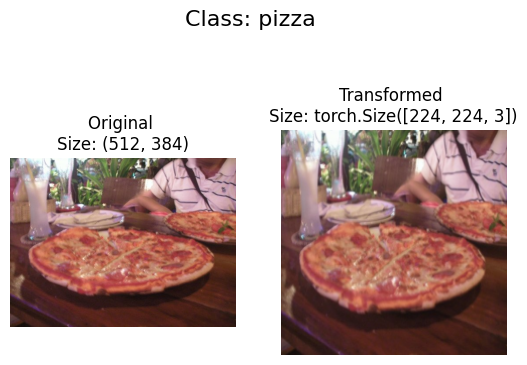

In [42]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n=3,
    seed = None
)

### Model 0: TinyVGG without data augmentation
Şimdi bir görüntünün pizza mı, biftek mi yoksa suşi mi olduğunu sınıflandırıp sınıflandıramayacağımızı görmek için bir bilgisayarla görme modeli oluşturalım.

Başlamak için basit bir dönüşümle başlayacağız, sadece görüntüleri (64, 64) olarak yeniden boyutlandırıp tensörlere dönüştüreceğiz.

#### 7.1 Creating transforms and loading data for Model 0



In [46]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

Bir diğer dönüşüm daha yapılacak.


1.   Verileri yükleyin, önce eğitim ve test klasörlerimizin her birini **torchvision.datasets.ImageFolder()** ile bir Veri Kümesine dönüştürün
2.   Daha sonra **torch.utils.data.DataLoader()**kullanarak bir DataLoader içine.
batch_size=32 ve num_workers değerlerini makinemizdeki CPU sayısına göre ayarlayacağız



In [48]:
# 1.Adım
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root =train_dir, transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir, transform = simple_transform)

#2.Adım
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

#create dataloader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle = True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x78d5055c5a80>,
 <torch.utils.data.dataloader.DataLoader at 0x78d5055c5600>)

#### 7.2 Create TinyVGG model class


In [51]:
class TinyVGG(nn.Module):
  """
   Model architecture copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  """

  def __init__(self, input_shape: int, hidden_units:int, output_shape: int) -> None:
     super().__init__()
     self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),

        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2) #default stride value is same as kernel_size
            )
     self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size =3, padding =1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
     )

  def forward(self,x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)